# Computer Vision Masterclass - Image Segmentation with Mask R-CNN

[Git Reference](https://github.com/alsombra/Mask_RCNN-TF2)

This is an implementation of [Mask R-CNN](https://arxiv.org/abs/1703.06870) on Python 3, Keras, and TensorFlow. The model generates bounding boxes and segmentation masks for each instance of an object in the image. It's based on Feature Pyramid Network (FPN) and a ResNet101 backbone.

## Importing the libraries

In [3]:
import os
import sys
import cv2
import numpy as np
import skimage.io
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf

2023-06-20 12:48:26.656894: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 12:48:27.996151: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
tf.__version__

'2.12.0'

In [6]:
ROOT_DIR = os.path.abspath('./data/Mask_RCNN-TF2')
ROOT_DIR

'/home/shailesh/CV/MyCode/data/Mask_RCNN-TF2'

In [7]:
sys.path

['/home/shailesh/CV/MyCode',
 '/home/shailesh/miniconda3/envs/torch/lib/python39.zip',
 '/home/shailesh/miniconda3/envs/torch/lib/python3.9',
 '/home/shailesh/miniconda3/envs/torch/lib/python3.9/lib-dynload',
 '',
 '/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages']

In [8]:
sys.path.append(ROOT_DIR)

In [9]:
sys.path

['/home/shailesh/CV/MyCode',
 '/home/shailesh/miniconda3/envs/torch/lib/python39.zip',
 '/home/shailesh/miniconda3/envs/torch/lib/python3.9',
 '/home/shailesh/miniconda3/envs/torch/lib/python3.9/lib-dynload',
 '',
 '/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages',
 '/home/shailesh/CV/MyCode/data/Mask_RCNN-TF2']

In [11]:
from mrcnn import utils
from mrcnn import visualize
import mrcnn.model as modellib

In [12]:
# https://cocodataset.org/#home
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))

In [13]:
sys.path

['/home/shailesh/CV/MyCode',
 '/home/shailesh/miniconda3/envs/torch/lib/python39.zip',
 '/home/shailesh/miniconda3/envs/torch/lib/python3.9',
 '/home/shailesh/miniconda3/envs/torch/lib/python3.9/lib-dynload',
 '',
 '/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages',
 '/home/shailesh/CV/MyCode/data/Mask_RCNN-TF2',
 '/home/shailesh/CV',
 '/home/shailesh/CV/MyCode/data/Mask_RCNN-TF2/samples/coco/']

In [16]:
import coco

In [17]:
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')
IMAGE_DIR = os.path.join(ROOT_DIR, 'images')

In [18]:
MODEL_DIR, IMAGE_DIR

('/home/shailesh/CV/MyCode/data/Mask_RCNN-TF2/logs',
 '/home/shailesh/CV/MyCode/data/Mask_RCNN-TF2/images')

### [ ! ] Compatibility Update
Run the 5 lines below so we don't have any issues when running with the latest versions of Tensorflow

In [19]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2023-06-20 13:01:01.359139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 13:01:01.467091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 13:01:01.467966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Loading the pre-trained neural network

In [20]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'mask_rcnn_coco.h5')

In [21]:
utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [22]:
class InferenceConfig(coco.CocoConfig):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

In [23]:
config = InferenceConfig()

In [24]:
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [25]:
MODEL_DIR

'/home/shailesh/CV/MyCode/data/Mask_RCNN-TF2/logs'

In [26]:
network = modellib.MaskRCNN(mode='inference', model_dir=MODEL_DIR, config=config)

Instructions for updating:
Use fn_output_signature instead


2023-06-20 13:07:18.493659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 13:07:18.494208: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 13:07:18.494569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [27]:
network.load_weights(COCO_MODEL_PATH, by_name=True)

2023-06-20 13:07:23.852373: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


## Detecting objects

In [28]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [29]:
len(class_names)

81

In [30]:
class_names[1], class_names.index('person')

('person', 1)

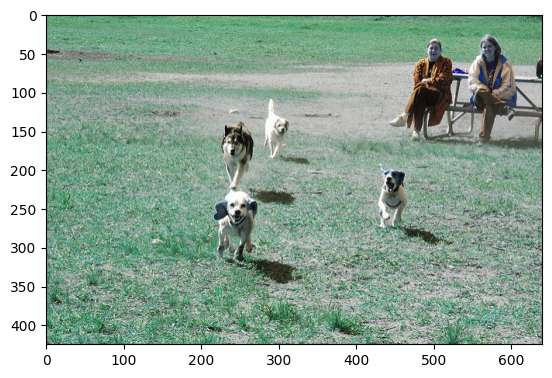

In [64]:
image2 = cv2.imread('Images/2516944023_d00345997d_z.jpg')
plt.imshow(image2); # BGR

In [32]:
image = skimage.io.imread('Images/2516944023_d00345997d_z.jpg') # RGB

In [59]:
# plt.imshow(image);

In [34]:
class_names[17], class_names[1], class_names[14]

('dog', 'person', 'bench')

In [35]:
results = network.detect([image], verbose=0)
results

/home/shailesh/miniconda3/envs/torch/lib/python3.9/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-06-20 13:10:35.897007: W tensorflow/c/c_api.cc:300] Operation '{name:'mrcnn_detection/Reshape_1' id:6831 op device:{requested: '', assigned: ''} def:{{{node mrcnn_detection/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](mrcnn_detection/packed, mrcnn_detection/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-20 13:10:38.413098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-06-20 13:10:44.178751: W tensorflow/tsl/framew

[{'rois': array([[195, 426, 277, 467],
         [226, 216, 321, 273],
         [106, 280, 189, 314],
         [ 32, 445, 159, 527],
         [136, 225, 231, 268],
         [ 27, 541, 168, 607],
         [ 75, 476, 164, 634]], dtype=int32),
  'class_ids': array([17, 17, 17,  1, 17,  1, 14], dtype=int32),
  'scores': array([0.9997004 , 0.9996582 , 0.9996049 , 0.99913245, 0.99799263,
         0.997436  , 0.9165013 ], dtype=float32),
  'masks': array([[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]],
  
         [[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
       

In [36]:
r = results[0]

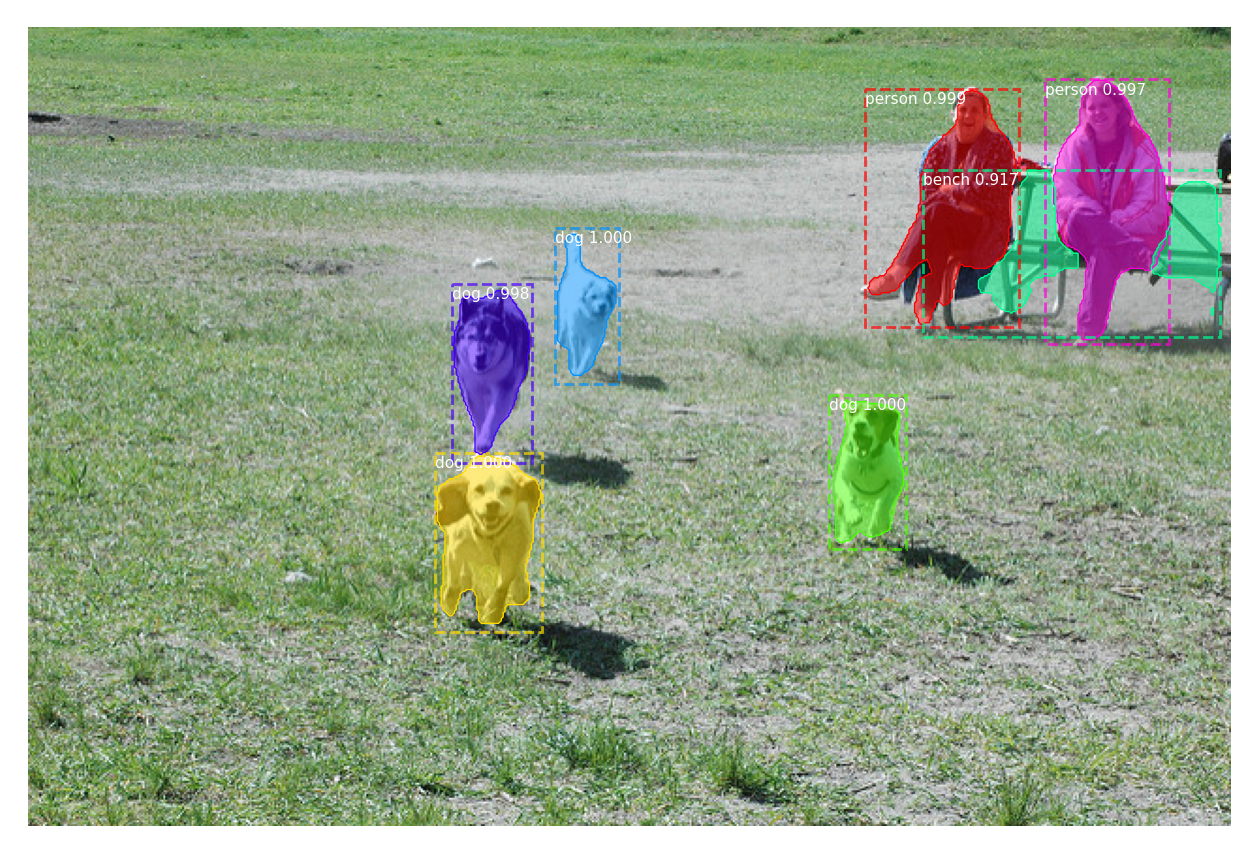

In [37]:
visualize.display_instances(image, r['rois'], r['masks'],
                            r['class_ids'], class_names, r['scores'])

## Removing the background

In [38]:
np.unique(r['masks'], return_counts=True)

(array([False,  True]), array([1881592,   22408]))

In [39]:
r['masks']

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [40]:
def segment(image, r, index):
  mask = r['masks'][:,:,index]
  #print(mask)
  #print(mask.shape)

  mask = np.stack((mask,) * 3, axis = -1)
  #print(mask)
  #print(mask.shape)

  mask = mask.astype('uint8')
  #print(mask)
  bg = 255 - mask * 255
  #print(mask, mask.min(), mask.max())

  mask_show = np.invert(bg)
  #print(mask_show)
  mask_img = image * mask
  #print(mask_img)

  result = mask_img + bg
  return result, mask_show

In [41]:
image.shape, 425 * 640

((425, 640, 3), 272000)

In [42]:
segmentation, mask_obj = segment(image, r, 0)

In [43]:
segmentation

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [44]:
mask_obj

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [45]:
def show_segment(image, r, index, show_mask = False):
  segmentation, mask_obj = segment(image, r, index)
  plt.subplots(1, figsize=(16,16))
  plt.axis('off')
  if show_mask == True:
    plt.imshow(np.concatenate([mask_obj, segmentation], axis = 1))
  else:
    plt.imshow(np.concatenate([image, segmentation], axis = 1))

In [60]:
# show_segment(image, r, 0, False)

In [61]:
# show_segment(image, r, 0, True)

In [48]:
r['rois'], len(r['rois'])

(array([[195, 426, 277, 467],
        [226, 216, 321, 273],
        [106, 280, 189, 314],
        [ 32, 445, 159, 527],
        [136, 225, 231, 268],
        [ 27, 541, 168, 607],
        [ 75, 476, 164, 634]], dtype=int32),
 7)

In [62]:
# for index in range(len(r['rois'])):
#   show_segment(image, r, index, True)

## Segmentation in videos

In [50]:
capture = cv2.VideoCapture('Videos/video_street2.mp4')
connected, frame = capture.read()
connected

True

In [ ]:
frame.shape

(720, 1280, 3)

In [51]:
save_video = cv2.VideoWriter('Videos/video_street2_result_seg.avi',
                             cv2.VideoWriter_fourcc(*'XVID'), 24, (frame.shape[1], frame.shape[0]))

In [52]:
from mrcnn import video_functions

In [53]:
colors = video_functions.random_colors(len(class_names), 55)
len(colors)

81

In [54]:
print(colors)

[(0.518518518518519, 0.0, 1.0), (1.0, 0.0, 0.14814814814814792), (0.37037037037037046, 1.0, 0.0), (0.0, 1.0, 0.5185185185185182), (1.0, 0.0, 0.5925925925925926), (1.0, 0.0, 0.518518518518519), (1.0, 0.0, 0.7407407407407405), (1.0, 0.5925925925925926, 0.0), (0.0, 1.0, 0.2962962962962963), (0.0, 1.0, 0.7407407407407405), (0.6666666666666667, 1.0, 0.0), (1.0, 0.07407407407407407, 0.0), (0.5925925925925926, 0.0, 1.0), (0.0, 0.5185185185185182, 1.0), (0.0, 1.0, 0.4444444444444442), (0.8888888888888884, 0.0, 1.0), (0.8888888888888888, 1.0, 0.0), (0.0, 0.8888888888888893, 1.0), (1.0, 0.2962962962962963, 0.0), (0.0, 0.2962962962962967, 1.0), (0.0740740740740744, 0.0, 1.0), (0.9629629629629628, 0.0, 1.0), (0.22222222222222232, 0.0, 1.0), (0.7407407407407409, 1.0, 0.0), (1.0, 0.6666666666666666, 0.0), (0.0, 1.0, 0.22222222222222232), (0.0, 1.0, 0.07407407407407396), (0.0, 1.0, 0.5925925925925926), (0.0, 0.44444444444444464, 1.0), (0.0, 0.8148148148148149, 1.0), (1.0, 0.5185185185185185, 0.0), (0

In [55]:
def show(img):
  fig = plt.gcf()
  fig.set_size_inches(16,10)
  plt.axis('off')
  plt.imshow(img)
  plt.show()

In [56]:
frame_show = 20
current_frame = 0

In [63]:
while (cv2.waitKey(1) < 0):
  connected, frame = capture.read()

  if not connected:
    break

  results = network.detect([frame], verbose=0)
  r = results[0]

  processed_frame = video_functions.display_instances(frame, r['rois'], r['masks'],
                                                      r['class_ids'], class_names, r['scores'], colors=colors)

  if current_frame <= frame_show:
#     show(processed_frame)
    current_frame += 1

  save_video.write(cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB))
save_video.release()